In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import * 
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from urllib.request import urlretrieve
from owslib.wfs import WebFeatureService
from dotenv import load_dotenv

# Create a spark session
spark = (
    SparkSession.builder.appName("analysis")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.driver.memory", "2g")
    .config("spark.executor.memory", "6g")
    .getOrCreate()
)

22/09/19 22:07:26 WARN Utils: Your hostname, AryansLaptop resolves to a loopback address: 127.0.1.1; using 172.28.41.58 instead (on interface eth0)
22/09/19 22:07:26 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


22/09/19 22:07:27 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
22/09/19 22:07:28 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
22/09/19 22:07:28 WARN Utils: Service 'SparkUI' could not bind on port 4041. Attempting port 4042.


In [2]:
sdf = spark.read.parquet("../data/curated/mergedf.parquet/")
merchantdf = spark.read.parquet("../data/curated/merchantdf.parquet/")
userdf = spark.read.parquet("../data/tables/consumer_user_details.parquet")
# transactiondf = spark.read.parquet("../data/curated/transactiondf.parquet/")

In [3]:
# This section of code will be removed and the comment in the cell above will turn into code once jai u update the
# analysis to include all 3 transaction sets
transactiondf1 = spark.read.parquet("../data/tables/transactions_20210228_20210827_snapshot/")
transactiondf2 = spark.read.parquet("../data/tables/transactions_20210828_20220227_snapshot/")
transactiondf = transactiondf1.union(transactiondf2)

## Revenue Band

  revenue_band  count
0            a   1602
1            b   1351
2            c    922
3            d     98
4            e     53
  revenue_band    count
0            a  6111561
1            b  3921368
2            c  3324800
3            d   136838
4            e   120108


<AxesSubplot:title={'center':'Distribution of Merchant Revenue Bands'}, ylabel='count'>

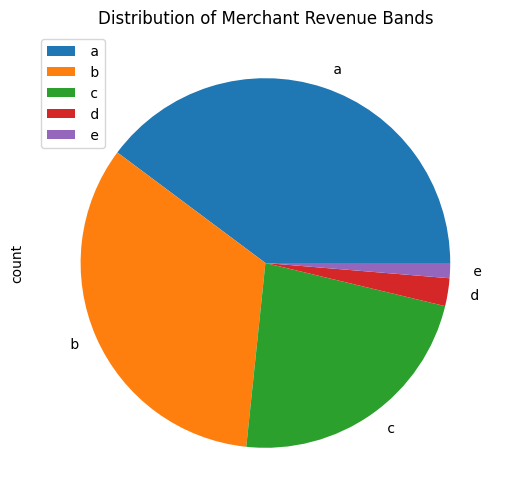

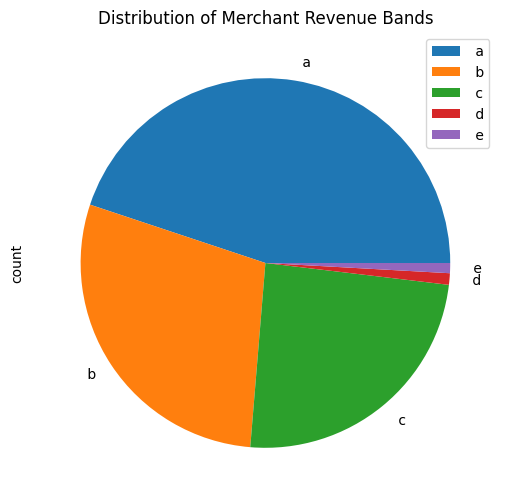

In [4]:
## Revenue Band
print(merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
merchantdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

## Now do all transactions have valid revenue bands?
print(sdf.groupby('revenue_band').count().sort('revenue_band').toPandas())
sdf.groupby('revenue_band').count().sort('revenue_band').toPandas().set_index('revenue_band')\
.plot(kind='pie', y='count', figsize=(9, 6), legend=True, title="Distribution of Merchant Revenue Bands")

Even after splitting from the tags field, we do not see any invalid entries in the revenue band field. The majority of revenue bands lie between a-c, with d and e revenue bands clearly being reserved for the most extreme merchants. Overall the number of merchants decreases as you reach higher revenue bands.

## Take Rate

           count
take_rate       
5.91        20.0
5.73        19.0
5.99        19.0
6.43        19.0
5.55        18.0
5.62        17.0
6.33        17.0
5.68        16.0
6.30        16.0
5.64        16.0
6.57        16.0
5.65        15.0
6.01        15.0
5.71        15.0
4.97        15.0
6.26        14.0
6.72        14.0
6.42        14.0
5.97        14.0
3.61        14.0
              count
take_rate          
2.94       311392.0
6.43       297787.0
2.86       281571.0
5.80       279430.0
1.47       265162.0
2.93       254986.0
6.01       249093.0
6.98       242944.0
6.48       210916.0
4.47       205855.0
6.33       148218.0
5.65       145981.0
5.73       117795.0
4.69       113398.0
6.61       106796.0
4.95       102819.0
5.97       102124.0
5.93        91702.0
6.16        86685.0
5.05        86567.0


Text(0, 0.5, 'Frequency')

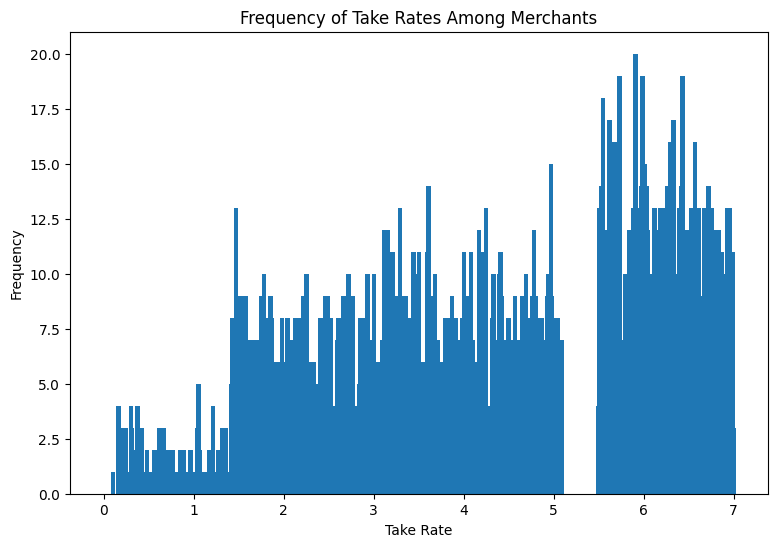

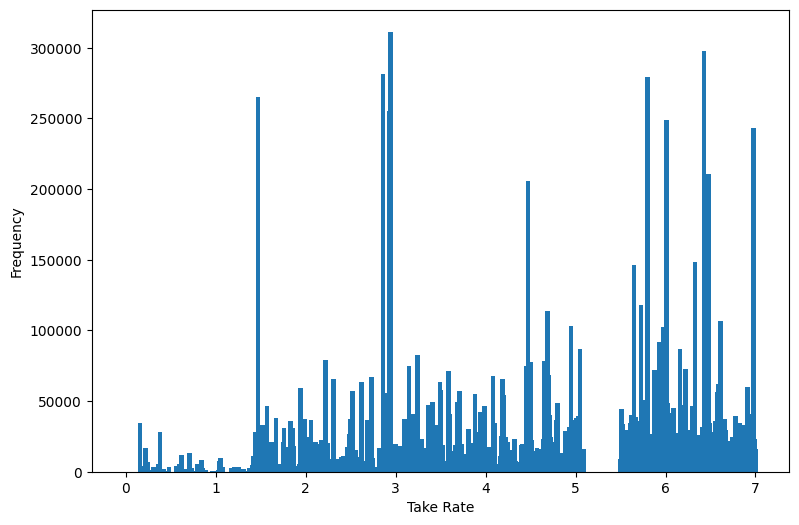

In [5]:
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = merchantdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)
print(takerate_df.sort_values('count', ascending=False).head(20))

fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')
plt.title('Frequency of Take Rates Among Merchants')


## Now do all transactions have valid take rates?
takerate_df = pd.DataFrame({"take_rate":np.arange(0, 7.01, 0.01), "count": 0})\
.set_index("take_rate")
takerate_df['count'] = sdf.groupby('take_rate').count().sort('take_rate')\
.toPandas().astype({'take_rate':'float'}).set_index('take_rate')
takerate_df = takerate_df.fillna(0)
print(takerate_df.sort_values('count', ascending=False).head(20))
fig, ax = plt.subplots(figsize=(9,6))
ax.bar(takerate_df.index, takerate_df['count'], width=0.05)
plt.xlabel('Take Rate')
plt.ylabel('Frequency')

There appears to be 3 distinct 'groups' in the distribution of take rate. The first comprising of very few merchants, which have a take rate between 0% and just over 1%. Rather logically, no merchants have a take rate of 0, and we don't see any nonsensical take rates either, such as negative take rates. 

The second group composes of merchants with a take take of just over 1% to roughly 5%. The number of merchants in this groups appears to have jumped significantly as compared to the previous group.

We notice a rather interesting pattern in that no merchants appear to have a take rate between just over 5% and roughly 5.5%. This could have something to do with the method used to determine take rate? Could make sense particularly with what appears to be 3 clear groups. 

The final group contains merchants between 5.5% take rate, and what appears to be the maximum possible take rate of 7%.

Finally, inside of each of the 3 groups, take rate appears to be uniformally distributed.

## Tags

In [6]:
merchantdf.groupby('tags').count().sort('tags').count()
merchantdf.groupby('tags').count().sort('tags').show(100, truncate=False)

# Now for transactions
sdf.groupby('tags').count().sort('tags').show(100, truncate=False)

+-------------------------------------------------------------------------------------+-----+
|tags                                                                                 |count|
+-------------------------------------------------------------------------------------+-----+
|antique shops - sales, repairs, and restoration services                             |129  |
|art dealers and galleries                                                            |112  |
|artist supply and craft shops                                                        |193  |
|bicycle shops - sales and service                                                    |170  |
|books, periodicals, and newspapers                                                   |164  |
|cable, satellite, and other pay television and radio services                        |175  |
|computer programming , data processing, and integrated systems design services       |191  |
|computers, computer peripheral equipment, and software     

After cleaning up the field, there are actually only 25 different unique values for tags, with these being fairly evenly distributed amongst merchants. This is a fairly interesting finding, since it was at first thought that this field was unique to each vendor, particularly given its nature as being a field manually entered

The maximum count shows 195 merchants with tag 'digital goods: books, movies, music' and minimum count shows 91 merchants with tag 'jewelry, watch, clock and silverware shops'.

Viewing the occurences of these tags in transactions instead reveals certain tags are associated with more/less frequent transactions. For example, 'jewelry, watch, clock, and silverware shops' merchants are seen to have by far the least frequent amount of transaction as opposed to 'tent and awning shops' which have the most by far.

# Consumer ID/User ID

In [7]:
print(userdf.groupby('consumer_id').count().sort(desc('count')))
print(userdf.groupby('consumer_id').count().sort(desc('count')).count())
print(userdf.groupby('user_id').count().sort(desc('count')))
print(userdf.groupby('user_id').count().sort(desc('count')).count())
print(transactiondf.groupby('user_id').count().sort('user_id').count())
print(transactiondf.groupby('user_id').count().sort('count'))

+-----------+-----+
|consumer_id|count|
+-----------+-----+
|    1174371|    1|
|     921339|    1|
|     612215|    1|
|    1493354|    1|
|     742966|    1|
|     567201|    1|
|     374960|    1|
|     653529|    1|
|     967705|    1|
|    1258545|    1|
|    1246796|    1|
|     287607|    1|
|     363321|    1|
|    1277685|    1|
|     617323|    1|
|    1371766|    1|
|      88291|    1|
|     295586|    1|
|      75264|    1|
|     582897|    1|
+-----------+-----+
only showing top 20 rows

499999
+-------+-----+
|user_id|count|
+-------+-----+
|     41|    1|
|    499|    1|
|    907|    1|
|   1085|    1|
|   1114|    1|
|   1273|    1|
|   1473|    1|
|   1574|    1|
|   1689|    1|
|   1695|    1|
|   1716|    1|
|   1783|    1|
|   2051|    1|
|   2171|    1|
|   2474|    1|
|   2556|    1|
|   2825|    1|
|   2935|    1|
|   3017|    1|
|   3108|    1|
+-------+-----+
only showing top 20 rows

499999


24081
+-------+-----+
|user_id|count|
+-------+-----+
|  11982|  285|
|  22367|  286|
|   8755|  289|
|   4760|  290|
|   2713|  291|
|  23378|  292|
|  21598|  292|
|   4794|  292|
|   9026|  294|
|  17995|  294|
|   6183|  295|
|   5989|  295|
|   1510|  296|
|  16332|  296|
|  13052|  296|
|   2150|  296|
|   8905|  296|
|  20629|  297|
|  12950|  297|
|  13951|  297|
+-------+-----+
only showing top 20 rows



There are no problems caused by joining this table (apart from the strange inclusion of a surrogate key). This table simply maps all user_ids from 0-499999 to some consumer_id. However, in the data given only user_ids up to 24,081 actually have at least 1 valid transaction in the dataset, meaning many of these mappings appear to go unused.

## Invalid Transactions

In [8]:
print(transactiondf.count() - sdf.count())

-5463303


By simply joining all tables to the transaction table via the relevant foreign keys, any transaction which can't be joined for some reason will be discarded. As seen above, this would mean that 333,642 transactions (as of the end of Week 2 data) would be simply discarded without our knowledge.

In [9]:
dropped_transactions = transactiondf.join(sdf, 'order_id', "leftanti")
dropped_transactions.count()

333642

In [10]:
dropped_transactions

order_id,user_id,merchant_abn,dollar_value,order_datetime
00010154-c8c6-492...,14132,43820812476,145.7508223047609,2021-04-03
0001f004-f3b9-479...,9553,48540087213,2535.012136880364,2021-03-24
000334fe-7ab8-4e7...,2438,11240426404,161.65965550330247,2021-05-01
0012083d-3d78-4a6...,21522,73121558118,76.2031996487711,2021-04-30
0016c89c-7e71-4c2...,9410,95492562735,30.124085051663126,2021-05-24
0017b5e7-2cf3-494...,2088,87802246756,184.15325198043612,2021-06-21
00230efc-c131-498...,20787,63966446164,172.42893653118102,2021-04-22
0027f8ee-7129-40f...,1138,20562405782,31.32315960689628,2021-05-24
0030f7a7-0684-45e...,845,29323795999,1.7872601666898336,2021-05-14
0034c517-9bfb-43e...,23639,32234779638,9.457439051443544,2021-03-10


In [11]:
print(dropped_transactions.filter(dropped_transactions.user_id > 24081))

+--------+-------+------------+------------+--------------+
|order_id|user_id|merchant_abn|dollar_value|order_datetime|
+--------+-------+------------+------------+--------------+
+--------+-------+------------+------------+--------------+



All transactions appear to have a valid user id.

In [12]:
print(dropped_transactions.groupby('merchant_abn').count().count())
print(dropped_transactions.groupby('merchant_abn').count().sort('merchant_abn'))
print(dropped_transactions.join(merchantdf, "merchant_abn"))

395


22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:18 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.
22/09/19 22:08:19 WARN RowBasedKeyValueBatch: Calling spill() on

22/09/19 22:08:20 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


22/09/19 22:08:21 WARN RowBasedKeyValueBatch: Calling spill() on RowBasedKeyValueBatch. Will not spill but return 0.


+------------+-----+
|merchant_abn|count|
+------------+-----+
| 10672322914|   64|
| 11029341140|   11|
| 11137507330| 1159|
| 11240426404|31216|
| 11358147682|   50|
| 11400713351|   35|
| 11839682616|  431|
| 12959561070|    1|
| 13129485817|    6|
| 13177076095|  185|
| 13226823813|  328|
| 13289167958|    7|
| 13494073581|   15|
| 13868849576|  469|
| 14827550074|  830|
| 15058508937|   23|
| 15073921424|   10|
| 15699401518|  142|
| 15862090061|  144|
| 16496390781|   44|
+------------+-----+
only showing top 20 rows



+------------+--------+-------+------------+--------------+------------+----+---------+------------+
|merchant_abn|order_id|user_id|dollar_value|order_datetime|company_name|tags|take_rate|revenue_band|
+------------+--------+-------+------------+--------------+------------+----+---------+------------+
+------------+--------+-------+------------+--------------+------------+----+---------+------------+



Therefore, all invalid transactions are shown to be dropped because they do not have a valid merchant_abn to link to. Maybe one might want to consider all these merchants as if they shared the same tag, however removing them would also seem sensible.

## Merchants

In [13]:
no_transaction_merchants = merchantdf.join(sdf.groupby('merchant_abn').count(), 'merchant_abn', "leftanti")
no_transaction_merchants

merchant_abn,company_name,tags,take_rate,revenue_band


There are therefore 7 merchants in the merchant dataframe that do not have a single transaction present in the transactional database as of yet. Of interest is their shared tags, only being either antique shops or jewelry etc. stores. We don't really have to remove these per say, they will exist in case any future transactions released have transactions of these merchants. 

In [14]:
# Jai based on your new outlier analysis with all 3 transactional data and removal of rows e.g. the < 0.01 transaction rows
# you needa write code here that basically
# gets the mergeddataset from curated tables, removes those outlier rows, and overwrites the merged dataset saved in tables folder
# make sure dataset has same name/directory after renaming